# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to: 
- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [9]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
print('Device:', device)

Device: cuda


In [10]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [11]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False, map_location=device)
model.to(device) 
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

1_label3.png: Pred: 1, Label: 3
3_label7.png: Pred: 3, Label: 7
2_label3.png: Pred: 1, Label: 3
0_label5.png: Pred: 1, Label: 5
4_label2.png: Pred: 6, Label: 2


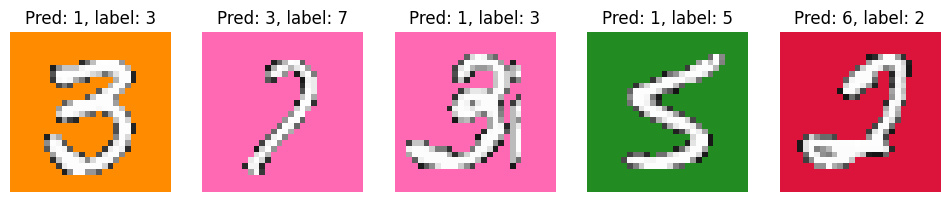

In [12]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

---
### Any code you want to add, put it below this markdown cell

In [13]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.xai import saliency_map, integrated_gradients, int_grad_alter_img, get_all_integrated_gradients

## Exploración Integrated Gradients

In [21]:
images_dir = Path('../data/MNIST/challenge')
challenge_dir = Path('../data/MNIST/challenge')
images_paths = sorted(images_dir.glob('*.png'))
challenge_paths = sorted(challenge_dir.glob('*.png'))
sample_images = [
    (int(img_file.stem[-1]), to_tensor(Image.open(img_file)).unsqueeze(0).to(device)) for img_file in images_paths
]

challenge_images = [
    (int(img_file.stem[-1]), to_tensor(Image.open(img_file)).unsqueeze(0).to(device)) for img_file in challenge_paths
]

In [16]:
ig_preds, ig_trues, ig_difs = get_all_integrated_gradients(model, challenge_images)

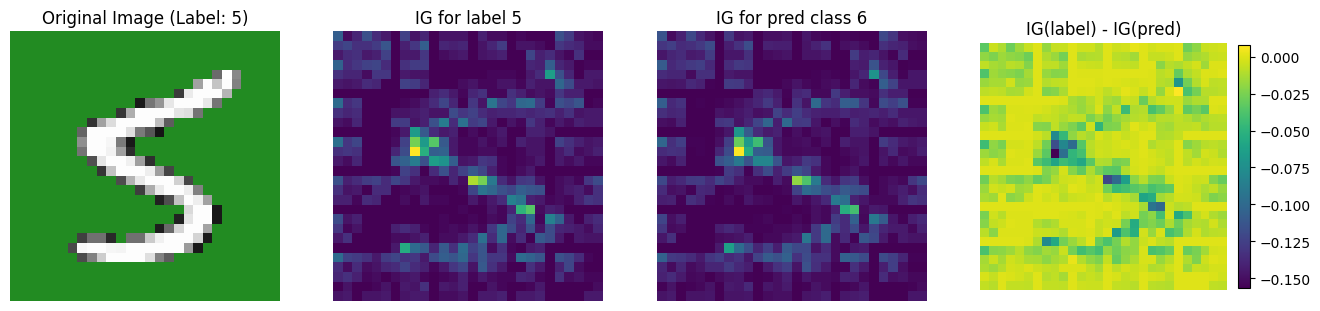

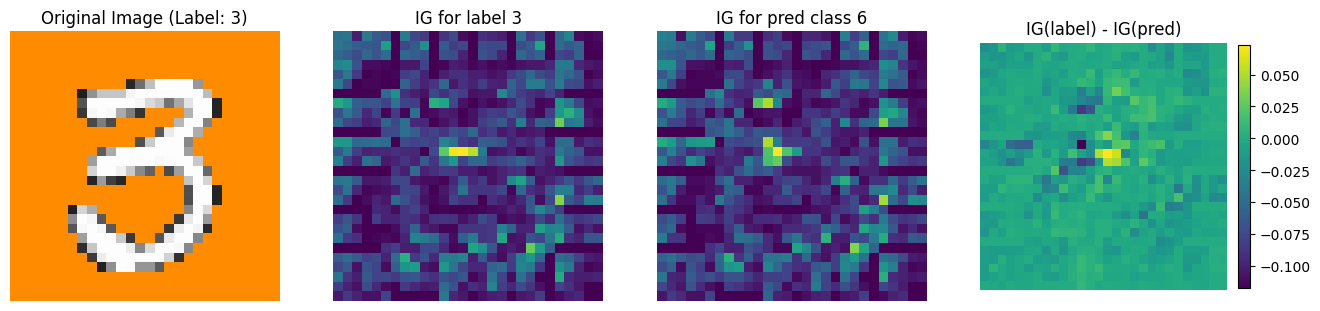

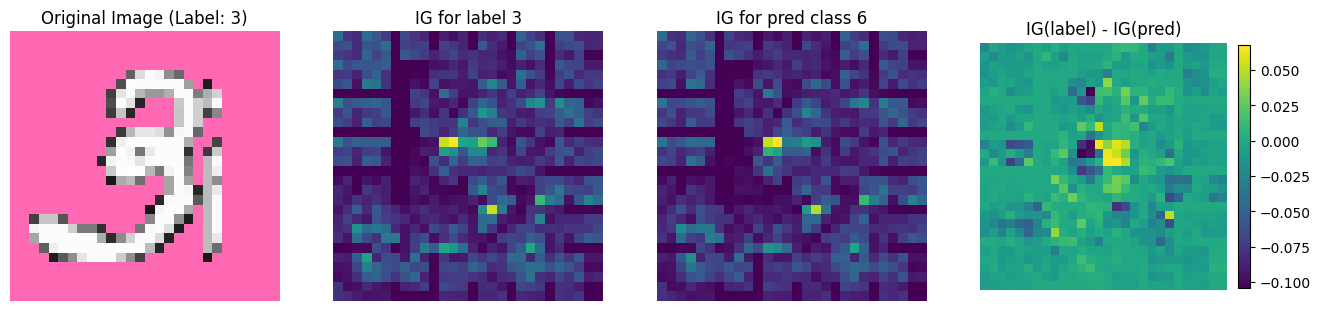

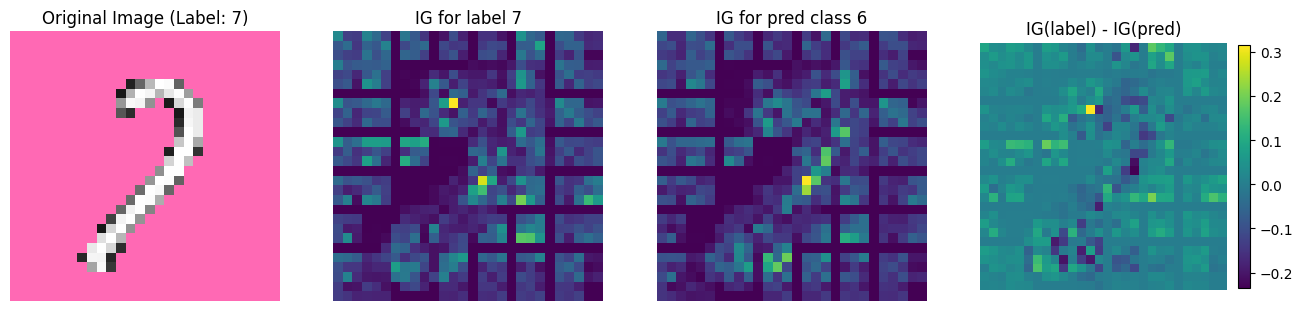

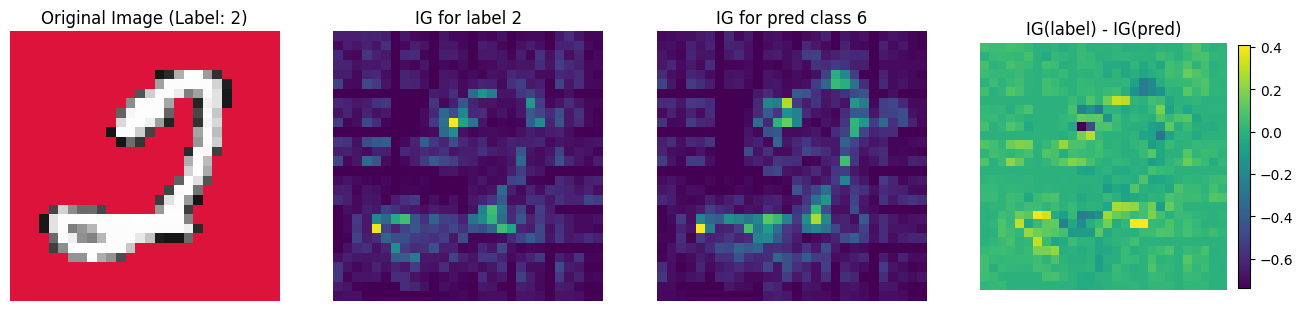

In [17]:
for image_idx in [0, 1, 2, 3, 4]:
    label, img = challenge_images[image_idx]
    ig_pred = ig_preds[image_idx]
    ig_true = ig_trues[image_idx]
    ig_dif = ig_difs[image_idx]
    
    fig, axes = plt.subplots(1, 4, figsize=(16,4))
    axes[0].imshow(to_pil(img.squeeze().cpu()))
    axes[0].set_title(f'Original Image (Label: {label})')
    axes[0].axis('off')
    axes[1].imshow(to_pil(ig_true.cpu()))
    axes[1].set_title(f'IG for label {label}')
    axes[1].axis('off')
    axes[2].imshow(to_pil(ig_pred.cpu()))
    axes[2].set_title(f'IG for pred class {pred}')
    axes[2].axis('off')
    ig_difs.append(ig_dif)
    axes[3].imshow(ig_dif.cpu())
    axes[3].set_title(f'IG(label) - IG(pred)')
    axes[3].axis('off')
    # Plot colorbar
    plt.colorbar(axes[3].images[0], ax=axes[3], fraction=0.045, pad=0.04)
    
    plt.show()

### Imágenes 4 y 5

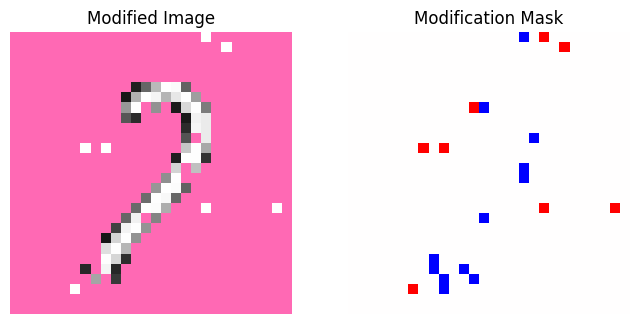

New prediction after modification: 7
Logits:
	Class 0: -2.0028
	Class 1: 0.4268
	Class 2: -2.3538
	Class 3: 0.8311
	Class 4: -1.5668
	Class 5: 0.8364
	Class 6: -0.8732
	Class 7: 1.0400
	Class 8: -1.1610
	Class 9: 0.6845


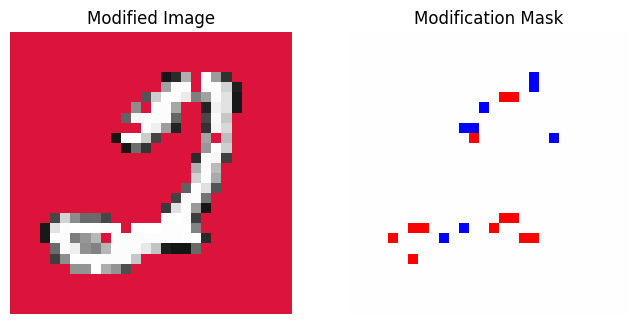

New prediction after modification: 2
Logits:
	Class 0: 3.8333
	Class 1: -20.3142
	Class 2: 7.2719
	Class 3: -18.9634
	Class 4: -0.1440
	Class 5: -12.4043
	Class 6: 6.7034
	Class 7: -23.1223
	Class 8: 0.7855
	Class 9: -22.3443


In [ ]:
for image_idx in [3, 4]:
    label, img = challenge_images[image_idx]
    # For the digits of ig_label which are (in absolute value) the largest, save the indices
    # ig_true = ig_trues[image_idx]
    ig_dif = ig_difs[image_idx]
    modified_img, mask_signed = int_grad_alter_img(img, ig_dif, modification_factor=0.025)

    # Plot modified image and mask
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    axes[0].imshow(to_pil(modified_img.squeeze().cpu()))
    axes[0].set_title('Modified Image')
    axes[0].axis('off')
    axes[1].imshow(mask_signed.squeeze().cpu(), cmap='bwr', vmin=-1, vmax=1)
    axes[1].set_title('Modification Mask')
    axes[1].axis('off')
    plt.show()

    # Make prediction on modified image
    with torch.no_grad():
        output = model(modified_img)
        pred = output.argmax(dim=1).item()
    print(f'New prediction after modification: {pred}')
    logits_dict = {i: logit for i, logit in enumerate(output.cpu().numpy()[0])}
    print(f"Logits:")
    for i, logit in logits_dict.items():
        print(f"\tClass {i}: {logit:.4f}")
    
    # Save modified image
    modified_img_pil = to_pil(modified_img.squeeze().cpu())
    modified_img_pil.save(f"{challenge_dir / 'edited' /challenge_paths[image_idx].stem}.png")

### Imagen 2

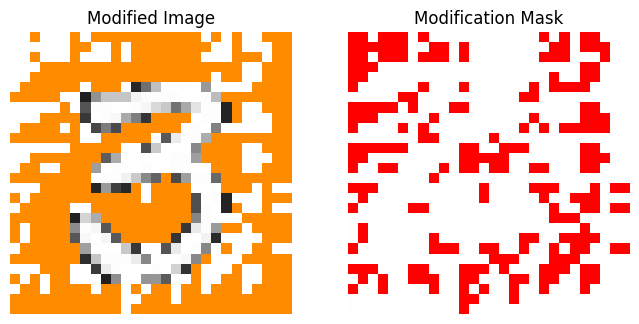

New prediction after modification: 3
Logits:
	Class 0: -1.5371
	Class 1: 1.1627
	Class 2: -2.0077
	Class 3: 1.2625
	Class 4: -1.7575
	Class 5: 1.1798
	Class 6: -1.0749
	Class 7: 0.7867
	Class 8: -1.0333
	Class 9: 0.3562


In [25]:
for image_idx in [1]:
    label, img = challenge_images[image_idx]
    # For the digits of ig_label which are (in absolute value) the largest, save the indices
    ig_true = ig_trues[image_idx]
    modified_img, mask_signed = int_grad_alter_img(img, ig_true, modification_factor=0.28)

    # Plot modified image and mask
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    axes[0].imshow(to_pil(modified_img.squeeze().cpu()))
    axes[0].set_title('Modified Image')
    axes[0].axis('off')
    axes[1].imshow(mask_signed.squeeze().cpu(), cmap='bwr', vmin=-1, vmax=1)
    axes[1].set_title('Modification Mask')
    axes[1].axis('off')
    plt.show()

    # Make prediction on modified image
    with torch.no_grad():
        output = model(modified_img)
        pred = output.argmax(dim=1).item()
    print(f'New prediction after modification: {pred}')
    logits_dict = {i: logit for i, logit in enumerate(output.cpu().numpy()[0])}
    print(f"Logits:")
    for i, logit in logits_dict.items():
        print(f"\tClass {i}: {logit:.4f}")

    # Save modified image
    modified_img_pil = to_pil(modified_img.squeeze().cpu())
    modified_img_pil.save(f"{challenge_dir / 'edited' /challenge_paths[image_idx].stem}.png")

### Imagen 1

Found modification factor: 0.3060606060606061


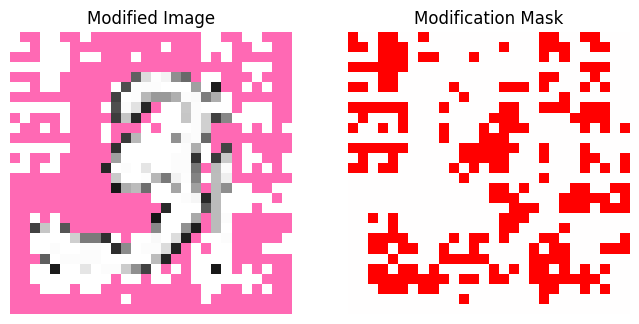

New prediction after modification: 3
Logits:
	Class 0: -1.4524
	Class 1: 1.2967
	Class 2: -1.9447
	Class 3: 1.3410
	Class 4: -1.7922
	Class 5: 1.2423
	Class 6: -1.1116
	Class 7: 0.7406
	Class 8: -1.0101
	Class 9: 0.2964


In [26]:
image_idx = 2

possible_factors = np.linspace(0.1, 0.4, 100)

for factor in possible_factors:
    label, img = challenge_images[image_idx]
    # For the digits of ig_label which are (in absolute value) the largest, save the indices
    ig_true = ig_trues[image_idx]
    modified_img, mask_signed = int_grad_alter_img(img, ig_true, modification_factor=factor)

    # Make prediction on modified image
    with torch.no_grad():
        output = model(modified_img)
        pred = output.argmax(dim=1).item()

    if pred == label:
        print(f'Found modification factor: {factor}')
        break

# Plot modified image and mask
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(to_pil(modified_img.squeeze().cpu()))
axes[0].set_title('Modified Image')
axes[0].axis('off')
axes[1].imshow(mask_signed.squeeze().cpu(), cmap='bwr', vmin=-1, vmax=1)
axes[1].set_title('Modification Mask')
axes[1].axis('off')
plt.show()


print(f'New prediction after modification: {pred}')
logits_dict = {i: logit for i, logit in enumerate(output.cpu().numpy()[0])}
print(f"Logits:")
for i, logit in logits_dict.items():
    print(f"\tClass {i}: {logit:.4f}")

# Save modified image
modified_img_pil = to_pil(modified_img.squeeze().cpu())
modified_img_pil.save(f"{challenge_dir / 'edited' /challenge_paths[image_idx].stem}.png")

---
## Check if you have passed the challenge 

In [27]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [28]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')


Edited 1_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 28.06%
Edited 3_label7.png: Pred: 7, Label: 7, correct: True
Edit Percentage: 2.04%
Edited 2_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 30.61%
Edited 0_label5.png: Pred: 1, Label: 5, correct: False
Edit Percentage: 0.00%
Edited 4_label2.png: Pred: 2, Label: 2, correct: True
Edit Percentage: 2.55%
